In [1]:
import numpy as np
from scipy import sparse
import pandas as pd

import re
import string
import time
import seaborn as sns
import itertools

In [2]:
import xgboost as xgb
#import lightgbm as lgb - will be used in following weeks
# from bayes_opt import BayesianOptimization - will be used in following weeks
import seaborn as sns
import matplotlib.pyplot as plt

import random
from sklearn import preprocessing, pipeline, metrics, model_selection
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neural_network import MLPClassifier
from IPython.display import display
import datetime

%matplotlib inline 

/Users/jyguo/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
train_data = pd.read_csv('../input/air_visit_data.csv')
train_size = train_data.shape[0]

In [4]:
full_data = pd.read_csv('../input/full_data.csv')

/Users/jyguo/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1,12,13,16,17,18,34,35,36,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Feature interactions

In [5]:
num_vars = ['dow', 'year', 'month', 'doy', 'dom', 'woy', 'holiday_flg',
            'date_index', 'date_int', 'air_stores_on_same_addr', 'hpg_stores_on_same_addr',
            'latitude_air', 'longitude_air', 
            'air_stores_on_same_addr', 'air_stores_lv1', 'air_stores_lv2',
            'mean_lat_air_lv1', 'max_lat_air_lv1', 'min_lat_air_lv1',
            'mean_lon_air_lv1', 'max_lon_air_lv1', 'min_lon_air_lv1',
            'mean_lat_air_lv2', 'max_lat_air_lv2', 'min_lat_air_lv2',
            'mean_lon_air_lv2', 'max_lon_air_lv2', 'min_lon_air_lv2',
            'latitude_hpg', 'longitude_hpg', 
            'hpg_stores_on_same_addr', 'hpg_stores_lv1', 'hpg_stores_lv2',
            'mean_lat_hpg_lv1', 'max_lat_hpg_lv1', 'min_lat_hpg_lv1',
            'mean_lon_hpg_lv1', 'max_lon_hpg_lv1', 'min_lon_hpg_lv1',
            'mean_lat_hpg_lv2', 'max_lat_hpg_lv2', 'min_lat_hpg_lv2',
            'mean_lon_hpg_lv2', 'max_lon_hpg_lv2', 'min_lon_hpg_lv2',
            'air_rvs', 'hpg_rvs','air_rv_dt_diff', 'hpg_rv_dt_diff']


cat_vars = ['air_store_id', 'air_genre_name', 'air_area_name', 'air_area_lv1', 'air_area_lv2', 'air_area_lv3',
            'hpg_store_id', 'hpg_genre_name', 'hpg_area_name', 'hpg_area_lv1', 'hpg_area_lv2', 'hpg_area_lv3']

id_var = 'air_store_id'
target_var = 'visitors'

### Categorical features - label encoding
Label encoding is not really necessary for this competition as all categorical features have already been digitalized.

In [6]:
LBL = preprocessing.LabelEncoder()

LE_vars=[]
LE_map=dict()
for cat_var in cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    LE_vars.append(LE_var)
    LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (LE_vars))

Label Encoding air_store_id
Label Encoding air_genre_name
Label Encoding air_area_name
Label Encoding air_area_lv1
Label Encoding air_area_lv2
Label Encoding air_area_lv3
Label Encoding hpg_store_id
Label Encoding hpg_genre_name
Label Encoding hpg_area_name
Label Encoding hpg_area_lv1
Label Encoding hpg_area_lv2
Label Encoding hpg_area_lv3
Label-encoded feaures: ['air_store_id_le', 'air_genre_name_le', 'air_area_name_le', 'air_area_lv1_le', 'air_area_lv2_le', 'air_area_lv3_le', 'hpg_store_id_le', 'hpg_genre_name_le', 'hpg_area_name_le', 'hpg_area_lv1_le', 'hpg_area_lv2_le', 'hpg_area_lv3_le']


### numeric to numeric

In [7]:
full_data.head()

,air_store_id,id,visit_date,visitors,dow,year,month,doy,dom,woy,...,air_area_name_le,air_area_lv1_le,air_area_lv2_le,air_area_lv3_le,hpg_store_id_le,hpg_genre_name_le,hpg_area_name_le,hpg_area_lv1_le,hpg_area_lv2_le,hpg_area_lv3_le
0,air_ba937bf13d40fb24,NaN,2016-01-13,25,2,2016,1,13,31,2,...,62,7,29,76,150,16,31,10,24,26
1,air_ba937bf13d40fb24,NaN,2016-01-14,32,3,2016,1,14,31,2,...,62,7,29,76,150,16,31,10,24,26
2,air_ba937bf13d40fb24,NaN,2016-01-15,29,4,2016,1,15,31,2,...,62,7,29,76,150,16,31,10,24,26
3,air_ba937bf13d40fb24,NaN,2016-01-16,22,5,2016,1,16,31,2,...,62,7,29,76,150,16,31,10,24,26
4,air_ba937bf13d40fb24,NaN,2016-01-18,6,0,2016,1,18,31,3,...,62,7,29,76,150,16,31,10,24,26


In [8]:
full_data['total_rvs'] = full_data['air_rvs'] + full_data['hpg_rvs']
full_data['mean_rvs_air_hpg'] = full_data[['air_rvs','hpg_rvs']].apply(lambda x:np.mean(x), axis=1)
full_data['mean_dt_diff_air_hpg'] = full_data[['air_rv_dt_diff','hpg_rv_dt_diff']].apply(lambda x:np.mean(x), axis=1)

# NEW FEATURES FROM Georgii Vyshnia ????
full_data['lon_plus_lat_air'] = full_data['longitude_air'] + full_data['latitude_air'] 

full_data['lat_to_mean_lat_air_lv1'] = abs(full_data['latitude_air']-full_data['mean_lat_air_lv1'])
full_data['lat_to_max_lat_air_lv1']  = full_data['latitude_air']-full_data['max_lat_air_lv1']
full_data['lat_to_min_lat_air_lv1']  = full_data['latitude_air']-full_data['min_lat_air_lv1']
full_data['lon_to_mean_lon_air_lv1']  = abs(full_data['longitude_air']-full_data['mean_lon_air_lv1'])
full_data['lon_to_max_lon_air_lv1']  = full_data['longitude_air']-full_data['max_lon_air_lv1']
full_data['lon_to_min_lon_air_lv1']  = full_data['longitude_air']-full_data['min_lon_air_lv1']
full_data['lat_to_mean_lat_air_lv2'] = abs(full_data['latitude_air']-full_data['mean_lat_air_lv2'])
full_data['lat_to_max_lat_air_lv2']  = full_data['latitude_air']-full_data['max_lat_air_lv2']
full_data['lat_to_min_lat_air_lv2']  = full_data['latitude_air']-full_data['min_lat_air_lv2']
full_data['lon_to_mean_lon_air_lv2'] = abs(full_data['longitude_air']-full_data['mean_lon_air_lv2'])
full_data['lon_to_max_lon_air_lv2']  = full_data['longitude_air']-full_data['max_lon_air_lv2']
full_data['lon_to_min_lon_air_lv2']  = full_data['longitude_air']-full_data['min_lon_air_lv2']

full_data['lat_to_mean_lat_hpg_lv1'] = abs(full_data['latitude_hpg']-full_data['mean_lat_hpg_lv1'])
full_data['lat_to_max_lat_hpg_lv1']  = full_data['latitude_hpg']-full_data['max_lat_hpg_lv1']
full_data['lat_to_min_lat_hpg_lv1']  = full_data['latitude_hpg']-full_data['min_lat_hpg_lv1']
full_data['lon_to_mean_lon_hpg_lv1']  = abs(full_data['longitude_hpg']-full_data['mean_lon_hpg_lv1'])
full_data['lon_to_max_lon_hpg_lv1']  = full_data['longitude_hpg']-full_data['max_lon_hpg_lv1']
full_data['lon_to_min_lon_hpg_lv1']  = full_data['longitude_hpg']-full_data['min_lon_hpg_lv1']
full_data['lat_to_mean_lat_hpg_lv2'] = abs(full_data['latitude_hpg']-full_data['mean_lat_hpg_lv2'])
full_data['lat_to_max_lat_hpg_lv2']  = full_data['latitude_hpg']-full_data['max_lat_hpg_lv2']
full_data['lat_to_min_lat_hpg_lv2']  = full_data['latitude_hpg']-full_data['min_lat_hpg_lv2']
full_data['lon_to_mean_lon_hpg_lv2'] = abs(full_data['longitude_hpg']-full_data['mean_lon_hpg_lv2'])
full_data['lon_to_max_lon_hpg_lv2']  = full_data['longitude_hpg']-full_data['max_lon_hpg_lv2']
full_data['lon_to_min_lon_hpg_lv2']  = full_data['longitude_hpg']-full_data['min_lon_hpg_lv2']

num_num_vars = ['total_rvs', 'mean_rvs_air_hpg',
       'mean_dt_diff_air_hpg', 'lon_plus_lat_air',
       'lat_to_mean_lat_air_lv1', 'lat_to_max_lat_air_lv1',
       'lat_to_min_lat_air_lv1', 'lon_to_mean_lon_air_lv1',
       'lon_to_max_lon_air_lv1', 'lon_to_min_lon_air_lv1',
       'lat_to_mean_lat_air_lv2', 'lat_to_max_lat_air_lv2',
       'lat_to_min_lat_air_lv2', 'lon_to_mean_lon_air_lv2',
       'lon_to_max_lon_air_lv2', 'lon_to_min_lon_air_lv2',
       'lat_to_mean_lat_hpg_lv1', 'lat_to_max_lat_hpg_lv1',
       'lat_to_min_lat_hpg_lv1', 'lon_to_mean_lon_hpg_lv1',
       'lon_to_max_lon_hpg_lv1', 'lon_to_min_lon_hpg_lv1',
       'lat_to_mean_lat_hpg_lv2', 'lat_to_max_lat_hpg_lv2',
       'lat_to_min_lat_hpg_lv2', 'lon_to_mean_lon_hpg_lv2',
       'lon_to_max_lon_hpg_lv2', 'lon_to_min_lon_hpg_lv2']

full_data.head()

,air_store_id,id,visit_date,visitors,dow,year,month,doy,dom,woy,...,lat_to_min_lat_hpg_lv1,lon_to_mean_lon_hpg_lv1,lon_to_max_lon_hpg_lv1,lon_to_min_lon_hpg_lv1,lat_to_mean_lat_hpg_lv2,lat_to_max_lat_hpg_lv2,lat_to_min_lat_hpg_lv2,lon_to_mean_lon_hpg_lv2,lon_to_max_lon_hpg_lv2,lon_to_min_lon_hpg_lv2
0,air_ba937bf13d40fb24,NaN,2016-01-13,25,2,2016,1,13,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,NaN,2016-01-14,32,3,2016,1,14,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,NaN,2016-01-15,29,4,2016,1,15,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,NaN,2016-01-16,22,5,2016,1,16,31,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,NaN,2016-01-18,6,0,2016,1,18,31,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### categorical to categorical

In [9]:
full_data['air_area_genre'] = full_data['air_area_name'] + '-' + full_data['air_genre_name'] 
full_data['air_store_dow'] = full_data['air_store_id'] + '-' + full_data['dow'].astype(str) 
full_data['air_store_dow_holiday'] = full_data['air_store_id'] + '-' + full_data['dow'].astype(str) + '-' + full_data['holiday_flg'].astype(str)

cat_cat_vars = ['air_area_genre','air_store_dow', 'air_store_dow_holiday']
full_data[cat_cat_vars].head()

,air_area_genre,air_store_dow,air_store_dow_holiday
0,Tōkyō-to Minato-ku Shibakōen-Dining bar,air_ba937bf13d40fb24-2,air_ba937bf13d40fb24-2-0
1,Tōkyō-to Minato-ku Shibakōen-Dining bar,air_ba937bf13d40fb24-3,air_ba937bf13d40fb24-3-0
2,Tōkyō-to Minato-ku Shibakōen-Dining bar,air_ba937bf13d40fb24-4,air_ba937bf13d40fb24-4-0
3,Tōkyō-to Minato-ku Shibakōen-Dining bar,air_ba937bf13d40fb24-5,air_ba937bf13d40fb24-5-0
4,Tōkyō-to Minato-ku Shibakōen-Dining bar,air_ba937bf13d40fb24-0,air_ba937bf13d40fb24-0-0


In [10]:
start = time.time()

LBL = preprocessing.LabelEncoder()

cat_cat_LE_vars=[]
cat_cat_LE_map=dict()
for cat_var in cat_cat_vars:
    print ("Label Encoding %s" % (cat_var))
    LE_var=cat_var+'_le'
    full_data[LE_var]=LBL.fit_transform(full_data[cat_var].astype(str))
    cat_cat_LE_vars.append(LE_var)
    cat_cat_LE_map[cat_var]=LBL.classes_
    
print ("Label-encoded feaures: %s" % (cat_cat_LE_vars))

end = time.time()
print(end - start)

Label Encoding air_area_genre
Label Encoding air_store_dow
Label Encoding air_store_dow_holiday
Label-encoded feaures: ['air_area_genre_le', 'air_store_dow_le', 'air_store_dow_holiday_le']
1.1824159622192383


### Target aggregation
This sometimes works for timeseries problems.

In [11]:
tmp = full_data[:train_size].groupby(['air_store_id','dow','holiday_flg'])['visitors'].\
            agg([np.mean, np.max, np.min, np.median]).\
            reset_index().\
            rename(columns={'mean':'mean_visitors',
                           'amax':'max_visitors',
                           'amin':'min_visitors',
                           'median':'median_visitors'})
            
full_data = pd.merge(full_data, tmp, how='left', on=['air_store_id','dow','holiday_flg'])

tmp = full_data[:train_size].groupby(['air_store_id','dow', 'holiday_flg']).\
            apply(lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )).\
            reset_index().rename(columns={0:'wmean_visitors'})
        
full_data = pd.merge(full_data, tmp, how='left', on=['air_store_id','dow','holiday_flg'])    
target_aggr_vars = ['mean_visitors', 'max_visitors', 'min_visitors', 'median_visitors', 'wmean_visitors']

## Modeling

We all run XGBoost models using a couple of combinations of features as well as with different missing value settings just to see how differently they perform.

### numerical features + label-encoded categorical features

In [12]:
full_data['visit_date'] = pd.to_datetime(full_data['visit_date'])

In [13]:
full_vars = num_vars + LE_vars + num_num_vars + cat_cat_LE_vars + target_aggr_vars
    
train = full_data[:train_size]
y = full_data[:train_size][target_var][:train_size].values
test = full_data[train_size:]
ids = full_data[train_size:][train_size:].id.values # ???

print ('train data size:', train.shape, 'test data size:', test.shape)    

train data size: (252108, 118) test data size: (32019, 118)


In [15]:
start = time.time()

train_x = train[(train['visit_date'] <= datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())][full_vars].values
train_y = np.log1p(train[(train['visit_date']<=datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date()) 
      & (train['visit_date']>datetime.datetime.strptime('2016-04-01', '%Y-%m-%d').date())]['visitors'].values)

val_x = train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())][full_vars].values
val_y = np.log1p(train[(train['visit_date']>datetime.datetime.strptime('2017-03-09', '%Y-%m-%d').date())]['visitors'].values)
print (train_x.shape, val_x.shape, train_x.shape[0]+ val_x.shape[0])


xgtrain = xgb.DMatrix(train_x, label=train_y)
xgval=xgb.DMatrix(val_x,label=val_y)

watchlist  = [ (xgtrain,'train'),(xgval,'eval')]


best_xgb_params = {'colsample_bytree': 0.7,
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 10,
 'min_child_weight': 3,
 'nthread': 8,
 'objective': 'reg:linear',
 'seed': 1234,
 'subsample': 1}

print (best_xgb_params)

model = xgb.train(best_xgb_params, 
                  xgtrain, 
                  num_boost_round=100000,
                  evals=watchlist,
                  early_stopping_rounds=50,
                  verbose_eval=50)    
best_iteration = model.best_iteration
best_score = model.best_score
print ('best_score: %f, best_iteration: %d' % (best_score, best_iteration))

end = time.time()
print("Running time is", (end - start))

(197019, 97) (31591, 97) 228610
{'colsample_bytree': 0.7, 'eta': 0.1, 'gamma': 1, 'max_depth': 10, 'min_child_weight': 3, 'nthread': 8, 'objective': 'reg:linear', 'seed': 1234, 'subsample': 1}
[0]	train-rmse:2.19634	eval-rmse:2.25232
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.446942	eval-rmse:0.470475
[100]	train-rmse:0.434886	eval-rmse:0.467693
Stopping. Best iteration:
[97]	train-rmse:0.435337	eval-rmse:0.467666

best_score: 0.467666, best_iteration: 97
Running time is 94.7674491405487


### Feature importance

,importance
doy,0.113670
wmean_visitors,0.095335
date_index,0.092055
mean_visitors,0.059736
max_visitors,0.049342
air_store_dow_le,0.038466
median_visitors,0.037119
min_visitors,0.031145
air_store_id_le,0.028141
air_genre_name_le,0.023618


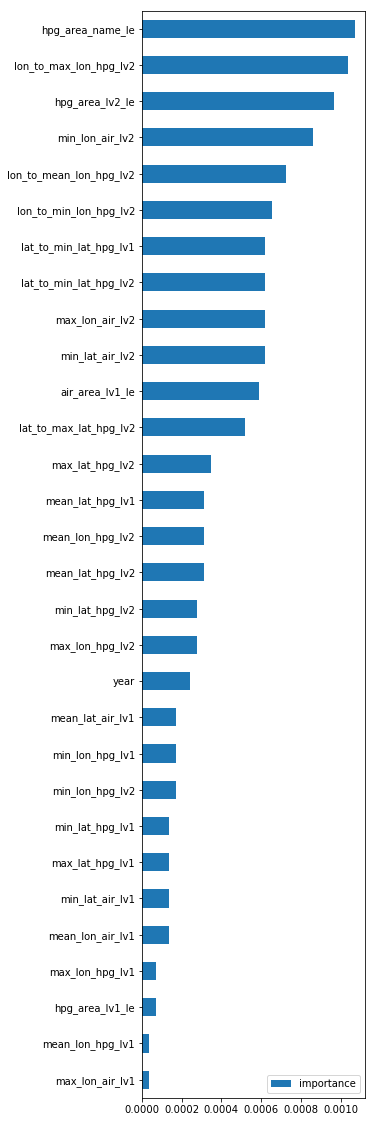

In [16]:
model.feature_names = full_vars
feature_importance = pd.DataFrame.from_dict(model.get_fscore(), orient='index')
feature_importance.columns = ['importance']
feature_importance.importance = feature_importance.importance/ feature_importance.importance.sum()
feature_importance.sort_values(by='importance').head(30).plot(kind='barh',figsize=(4,20))
feature_importance.sort_values(by='importance',ascending=False).head(30)

### Create submission

In [17]:
train_x = train[full_vars].values
train_y = np.log1p(train['visitors'].values)
model = xgb.train(best_xgb_params, 
                  xgb.DMatrix(train_x, label=train_y), 
                  num_boost_round=best_iteration)    
test['visitors'] = model.predict(xgb.DMatrix(test[full_vars].values))
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub = test[['id','visitors']].copy()
#sub[['id', 'visitors']].to_csv('../output/sub_starter.csv', index=False)

/Users/jyguo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jyguo/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


## Model tuning

### Createa a parameter space

In [18]:
default_xgb_params = {}
default_xgb_params["objective"] = "reg:linear"
default_xgb_params["eta"] = 0.1
default_xgb_params["seed"] = 1234

params_xgb_space = {}
params_xgb_space['max_depth'] = [4,5,6,7,8,9,10]
params_xgb_space['gamma'] = [0, 0.1, 0.3, 1, 1.5, 2, 3]
params_xgb_space['colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['subsample'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
params_xgb_space['min_child_weight'] = [0, 1, 3, 10, 30, 100]

greater_is_better = False

In [20]:
start = time.time()
best_xgb_params = default_xgb_params
for p in params_xgb_space:
    print ("Tuning parameter %s in %s" % (p, params_xgb_space[p]))

    params = best_xgb_params
    scores = []    
    for v in params_xgb_space[p]:
        print ('    %s: %s' % (p, v), end="")
        params[p] = v
        model = xgb.train(params, 
                      xgtrain, 
                      num_boost_round=100000,
                      evals=watchlist,
                      early_stopping_rounds=50,
                      verbose_eval=False)    
        best_iteration = model.best_iteration
        best_score = model.best_score
        print (', best_score: %f, best_iteration: %d' % (best_score, best_iteration))
        scores.append([v, best_score])
    # best param value in the space
    best_param_value = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][0]
    best_param_score = sorted(scores, key=lambda x:x[1],reverse=greater_is_better)[0][1]
    best_xgb_params[p] = best_param_value
    print ("Best %s is %s with a score of %f" %(p, best_param_value, best_param_score))

end = time.time()
print("Running time is", (end - start))

Tuning parameter max_depth in [4, 5, 6, 7, 8, 9, 10]
    max_depth: 4, best_score: 0.469041, best_iteration: 698
    max_depth: 5, best_score: 0.467723, best_iteration: 379
    max_depth: 6, best_score: 0.466854, best_iteration: 318
    max_depth: 7, best_score: 0.470178, best_iteration: 240
    max_depth: 8, best_score: 0.468991, best_iteration: 176
    max_depth: 9, best_score: 0.472024, best_iteration: 86
    max_depth: 10, best_score: 0.471344, best_iteration: 69
Best max_depth is 6 with a score of 0.466854
Tuning parameter gamma in [0, 0.1, 0.3, 1, 1.5, 2, 3]
    gamma: 0, best_score: 0.466854, best_iteration: 318
    gamma: 0.1, best_score: 0.468861, best_iteration: 280
    gamma: 0.3, best_score: 0.468016, best_iteration: 417
    gamma: 1, best_score: 0.472837, best_iteration: 216
    gamma: 1.5, best_score: 0.477469, best_iteration: 108
    gamma: 2, best_score: 0.478269, best_iteration: 145
    gamma: 3, best_score: 0.478186, best_iteration: 135
Best gamma is 0 with a score of

### Automated tuning